In [ ]:
pip install 'import_ipynb'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
  
%cd /content/drive/My\ Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root
 
 
import import_ipynb
from cifar100_Rseed import cifar_100
from net import resnet32

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/MLDLProjects/Lande_Napolitano_Pipoli/Project_root
importing Jupyter notebook from cifar100_Rseed.ipynb
IMPORT CIFAR DONE Rseed
importing Jupyter notebook from net.ipynb
IMPORT NET DONE


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix as s_cm
import seaborn as sn
import matplotlib.patches as mpatches

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


iCarl Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
from PIL import Image
from net import resnet32
import torchvision
import torchvision.transforms as transforms

import math
from sklearn.preprocessing import normalize
import copy



class iCaRLNet(nn.Module):
    def __init__(self, feature_size, n_classes, lr=0.2, gamma=0.2, weight_decay=1e-5, milestone=[49, 63], batch_size=128, num_epochs=70, momentum=0.9):
        # Network architecture
        super(iCaRLNet, self).__init__()
        self.net = resnet32(num_classes=n_classes)
        self.feature_extractor = self.net.get_fm_out
        self.lr = lr
        self.gamma = gamma
        self.weight_decay = weight_decay
        self.milestone = milestone
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.n_classes = 0
        self.n_known = 0
        self.momentum = momentum
        self.classificationLoss = []
        self.distillationLoss = []
        # List containing exemplar_sets
        # Each exemplar_set is a np.array of N images
        # with shape (N, C, H, W)
        self.exemplar_sets = []

        # Learning method
        self.MSE= nn.MSELoss() 
        self.BCEwithL = nn.BCEWithLogitsLoss()  #reduction 
        self.cls_loss = nn.CrossEntropyLoss()
        self.dist_loss = nn.BCELoss()   

        # Means of exemplars
        self.compute_means = True
        self.exemplar_means = []


    def forward(self, x):
      self.net = self.net.cuda()
      return self.net.forward(x)


    def increment_classes(self, n):
        """Add n classes in the final fc layer"""
        in_features = self.fc.in_features
        out_features = self.fc.out_features
        weight = self.fc.weight.data

        self.fc = nn.Linear(in_features, out_features + n, bias=False)
        self.fc.weight.data[:out_features] = weight
        self.n_classes += n

    def classify(self, x, cif):
        

        if self.compute_means:
            print("Computing mean of exemplars...")
            exemplar_means = []
            for P_y in self.exemplar_sets:  #P_y list of indices
                features = np.zeros((0,64))
                sub = Subset(cif, P_y)
                dl = torch.utils.data.DataLoader(sub, batch_size=self.batch_size,
                                               shuffle=False, num_workers=4)
                # Extract feature for each exemplar in P_y
                with torch.no_grad():
                  for ind, ex, lab in dl:
                    ex = Variable(ex).cuda()
                    feature = self.feature_extractor(ex).data.cpu().numpy()
                    feature = normalize(feature, axis=1, norm='l2')
                    features = np.concatenate((features,feature), axis=0)

                features = torch.tensor(features)
                mu_y = features.mean(0).squeeze()
                mu_y.data = mu_y.data / torch.norm(mu_y, p=2)  # L2 Normalize
                exemplar_means.append(mu_y)

            self.exemplar_means = exemplar_means
            self.compute_means = False
            print("Done")


        exemplar_means = self.exemplar_means
        means = torch.stack(exemplar_means)  # (n_classes, feature_size)
        means = torch.stack([means] * self.batch_size)  # (batch_size, n_classes, feature_size)
        means = means.transpose(1, 2)  # (batch_size, feature_size, n_classes)
        feature = self.feature_extractor(x)  # (batch_size, feature_size)
        for i in range(feature.size(0)):  # Normalize
            feature.data[i] = feature.data[i] / torch.norm(feature.data[i], p=2)
        feature = feature.unsqueeze(2)  # (batch_size, feature_size, 1)
        feature = feature.expand_as(means)  # (batch_size, feature_size, n_classes)
        feature = feature.cuda()
        means = means.cuda()
        dists = torch.sqrt((feature - means).pow(2).sum(1)).squeeze()  # (batch_size, n_classes)
        _, preds = dists.min(1) 
        return preds

    def construct_exemplar_set(self, images, m):
        
        # Compute and cache features for each example
        features = np.zeros((0,64))
        indices = np.zeros((0), dtype=int)
        dl = torch.utils.data.DataLoader(images, batch_size=self.batch_size,
                                               shuffle=False, num_workers=4)
        with torch.no_grad():
          for ind, img, lab in dl:
            x = Variable(img).cuda()
            feature = self.feature_extractor(x).data.cpu().numpy()
            feature = normalize(feature, axis=1, norm='l2')
            features = np.concatenate((features,feature), axis=0)
            indices = np.concatenate((indices,ind), axis=0)

       
        class_mean = np.mean(features, axis=0)
        class_mean = class_mean / np.linalg.norm(class_mean)  # Normalize
        exemplar_set = []
        exemplar_features = np.zeros((0,64))

        for k in range(1, int(m)+1):
            S = np.sum(exemplar_features, axis=0)
            phi = features
            mu = class_mean
            mu_p = 1.0 / k * (phi + S)
            mu_p = normalize(mu_p, axis=1, norm='l2')
            i = np.argmin(np.sqrt(np.sum((mu - mu_p) ** 2, axis=1)))
            exemplar_set.append(indices[i])
            addfeature =  np.expand_dims(features[i], axis=0)
            exemplar_features = np.concatenate((exemplar_features,addfeature), axis=0)
            #remove duplicates
            features = np.delete(features, i, 0)
            indices = np.delete(indices, i, 0)
        self.exemplar_sets.append(exemplar_set)
        


    def reduce_exemplar_sets(self, m):
        for y, P_y in enumerate(self.exemplar_sets):
            self.exemplar_sets[y] = P_y[:int(m)]

    def combine_dataset_with_exemplars(self, cifar):
        newindexes = []
        for y, P_y in enumerate(self.exemplar_sets):
            exemplar_images = P_y
            exemplar_labels = [y] * len(P_y)
            print(exemplar_images[0].shape)
            newindexes+=cifar.data_append(exemplar_images, exemplar_labels)
        return newindexes

    def exemplarIndexes(self):
      Indexes = []
      for P_y in self.exemplar_sets:
        Indexes += P_y
      return Indexes


    def update_representation(self, cifar, batchindexes, diz, file):
        prev_model = copy.deepcopy(self)
        prev_model = prev_model.eval().cuda()
        self.compute_means = True
        self.n_classes += 10
        print(len(batchindexes))
        # Form combined training set
        newindexes = []
        if self.n_classes > 10:
          newindexes = self.exemplarIndexes() 
        newindexes += list(batchindexes)
        print(len(newindexes))
        reprdata = Subset(cifar, newindexes)

        loader = torch.utils.data.DataLoader(reprdata, batch_size=self.batch_size,
                                             shuffle=True, num_workers=4, drop_last=True)

        # Run network training

        optimizer = optim.SGD(self.net.parameters(), lr=self.lr, weight_decay=self.weight_decay, momentum=self.momentum)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.milestone, gamma=self.gamma)

        
        print("TRAIN")
        for epoch in range(self.num_epochs):
            losses = []
            classlosses = []
            distlosses = []
            for indices, images, labels in loader:
              labels = torch.tensor([torch.tensor(diz[c.item()]) for c in labels])
              images = Variable(torch.FloatTensor(images)).cuda()
              labels = Variable(labels).cuda()
              optimizer.zero_grad()
              g = self.forward(images)
              y_hot = F.one_hot(labels, self.n_classes).float().cuda()
              # cause hot are long and sigmoid is float/double

              if self.n_known > 0:
                q = prev_model.forward(images)
                q = torch.sigmoid(q)
                distloss = self.BCEwithL(g[:,:self.n_known],q[:,:self.n_known])
                distlosses.append(distloss.item())
                indexes = []

                for i, li in enumerate(labels):
                  if li > self.n_known:
                    indexes.append(i)

                loss = self.cls_loss(g[indexes,:], labels[indexes]) 
                classlosses.append(loss.item())
                loss += distloss

              else:
                loss = self.cls_loss(g, labels) 
                classlosses.append(loss.item())

              losses.append(loss.item())
              loss.backward()
              optimizer.step()

            #save data for plot
            self.classificationLoss.append(np.mean(np.array(classlosses)))
            if len(distlosses) == 0:
              self.distillationLoss.append(0)
            else:
              self.distillationLoss.append(np.mean(np.array(distlosses)))


            if(epoch + 1) % 5 == 0:
              if len(distlosses) == 0:
                mean_dist = 0
              else:
                mean_dist = np.mean(np.array(distlosses))
              print('Epoch [%d/%d], Average_Loss(tot, dist, class): %.4f, %.4f, %.4f' \
                    % (epoch + 1, self.num_epochs, np.mean(np.array(losses)), mean_dist, np.mean(np.array(classlosses))), file=file)
              print('Epoch [%d/%d], Average_Loss(tot, dist, class): %.4f, %.4f, %.4f' \
                    % (epoch + 1, self.num_epochs, np.mean(np.array(losses)), mean_dist, np.mean(np.array(classlosses))))
            scheduler.step()

    def compute_confusion_matrix(self, cif, plot=False, title="Title"):
      
        cifar_test = cifar_100(100, 'test')
        dl = torch.utils.data.DataLoader(cifar_test, batch_size=128,shuffle=True, num_workers=4, drop_last=True)
        mapper = cif.get_dictionary()
        y_true = []
        y_pred = []
        for _, images, labels in dl:
            images = Variable(images).cuda()
            y_true.extend(labels)
            y_pred_tmp = self.classify(images, cif)
            y_pred_tmp = [p.item() for p in y_pred_tmp]
            y_pred.extend(y_pred_tmp)
        
        y_true = [mapper[l.item()] for l in y_true]
        acc_matrix = s_cm(y_true, y_pred)

        if plot:
            plt.figure(figsize=(11,11))
            df_cm = pd.DataFrame(acc_matrix)
            sn.heatmap(df_cm, square=True, xticklabels=20, yticklabels=20)
            plt.title(f"{title} confusion matrix")
            plt.show()

        return acc_matrix

    def plotLosses(self, title = "Title"):
      plt.rcParams['font.size'] = 22
      x=np.arange(1, self.num_epochs*self.n_classes/10+1, 1)
      plt.figure(figsize=(30, 15))
      b_patch = mpatches.Patch(color='blue', label='Classification Loss')
      r_patch = mpatches.Patch(color='red', label='Distillation Loss')
      plt.legend(handles=[b_patch,r_patch])
      plt.plot(x ,self.distillationLoss,'r', x, self.classificationLoss,'b')
      plt.title(f"{title} Loss")
      xT=np.arange(0, self.num_epochs*self.n_classes/10+1, self.num_epochs)
      plt.xticks(xT)
      plt.savefig(f'1_accStats.png')
      plt.show()

Main

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

torch.cuda.current_device()
torch.cuda._initialized = True
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)


# Hyper Parameters
total_classes = 100
num_classes = 10

def accuracy_on(dl, model, cif):
  total = 0
  correct = 0
  
  # it iterates over a data loader so it returns batches of data
  for ind, images, labels in dl: 
    labels = torch.tensor([torch.tensor(diz[c.item()]) for c in labels])
    images = Variable(images).cuda()
    pred = model.classify(images, cif)#.cuda()
    total += len(labels)

    n = 0
    for p, l in zip(pred, labels):
      if p == l:
        n += 1
    correct += n

  return correct / total

# Initialize CNN
K = 2000  # total number of exemplars
icarl = iCaRLNet(64, 100, num_epochs=70, lr=0.2)
icarl = icarl.to(DEVICE)
BATCH_SIZE = 128
acc_vect = []

randomseed = 981
cifarTrain = cifar_100(num_classes, 'train', randomseed)
cifarTest = cifar_100(num_classes, 'test', randomseed)
randomlist = cifarTrain.get_classes_list()
diz = cifarTrain.get_dictionary()

with open("03 - Print CE BCE.txt", 'w') as file:
  for s in range(10):
      # Load Datasets
      print("Loading training examples for classes", randomlist[s*num_classes:s*num_classes + num_classes], file=file)
      print("Loading training examples for classes", randomlist[s*num_classes:s*num_classes + num_classes])
      batchindexes = cifarTrain.getClassIndexes(randomlist[s*num_classes:s*num_classes + num_classes])
      batch = Subset(cifarTrain, batchindexes)

      print("Batch size: {}".format(len(batch)))
      testindexes = cifarTest.getClassIndexes(randomlist[0:s*num_classes + num_classes])
      test_set = Subset(cifarTest, testindexes)


      train_loader = torch.utils.data.DataLoader(batch, batch_size=BATCH_SIZE,
                                                shuffle=True, num_workers=4, drop_last=True)

      test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                                shuffle=False, num_workers=4, drop_last=True)


      # Update representation via BackProp
      icarl.train()
      icarl.update_representation(cifarTrain, batchindexes, diz, file)
      icarl.eval()
      m = K / icarl.n_classes

      # Reduce exemplar sets for known classes
      icarl.reduce_exemplar_sets(m)

      # Construct exemplar sets for new classes
      for y in randomlist[s*num_classes:s*num_classes + num_classes]:
          print("Constructing exemplar set for class-%d..." % (y))
          imagesInd = cifarTrain.getClassIndexes([y])
          images = Subset(cifarTrain, imagesInd)
          icarl.construct_exemplar_set(images, m)
          print("Done exemplars")

      icarl.n_known = icarl.n_classes
      print("iCaRL classes: %d" % icarl.n_known)

      total = 0.0
      correct = 0.0

      print(len(train_loader))
      for indices, images, labels in train_loader:
          labels = [torch.tensor(diz[c.item()]) for c in labels]
          labels = torch.tensor(labels)
          images = Variable(images).cuda()
          preds = icarl.classify(images, cifarTrain)
          total = total + len(labels)
          correct += (preds.data.cpu() == labels).sum()

      print('Train Accuracy: %.4f %%' % (100.0 * correct / total), file=file)
      print('Train Accuracy: %.4f %%' % (100.0 * correct / total))
      print(f'Train Accuracy: {accuracy_on(train_loader, icarl, cifarTrain)}')
      total = 0.0
      correct = 0.0

      for indices, images, labels in test_loader:
          labels = [torch.tensor(diz[c.item()]) for c in labels]
          labels = torch.tensor(labels)
          images = Variable(images).cuda()
          preds = icarl.classify(images, cifarTrain)
          total = total + len(labels)
          correct += (preds.data.cpu() == labels).sum()

      print('Test Accuracy: %.4f %%' % (100.0 * correct / total), file=file)
      print('Test Accuracy: %.4f %%' % (100.0 * correct / total))
      print(f'Train Accuracy: {accuracy_on(test_loader, icarl, cifarTrain)}')
      acc_vect.append(100.0 * correct.item() / total)
      

  print(acc_vect)
  print(acc_vect, file=file)

cuda
Files already downloaded and verified
Files already downloaded and verified
Loading training examples for classes [28, 7, 17, 45, 46, 91, 63, 13, 95, 59]
Batch size: 5000
5000
5000
TRAIN
Epoch [5/70], Average_Loss(tot, dist, class): 1.5858, 0.0000, 1.5858
Epoch [10/70], Average_Loss(tot, dist, class): 1.2590, 0.0000, 1.2590
Epoch [15/70], Average_Loss(tot, dist, class): 1.0312, 0.0000, 1.0312
Epoch [20/70], Average_Loss(tot, dist, class): 0.8117, 0.0000, 0.8117
Epoch [25/70], Average_Loss(tot, dist, class): 0.6378, 0.0000, 0.6378
Epoch [30/70], Average_Loss(tot, dist, class): 0.5160, 0.0000, 0.5160
Epoch [35/70], Average_Loss(tot, dist, class): 0.4335, 0.0000, 0.4335
Epoch [40/70], Average_Loss(tot, dist, class): 0.3080, 0.0000, 0.3080
Epoch [45/70], Average_Loss(tot, dist, class): 0.2641, 0.0000, 0.2641
Epoch [50/70], Average_Loss(tot, dist, class): 0.1404, 0.0000, 0.1404
Epoch [55/70], Average_Loss(tot, dist, class): 0.0708, 0.0000, 0.0708
Epoch [60/70], Average_Loss(tot, dist, 

Plots


Files already downloaded and verified


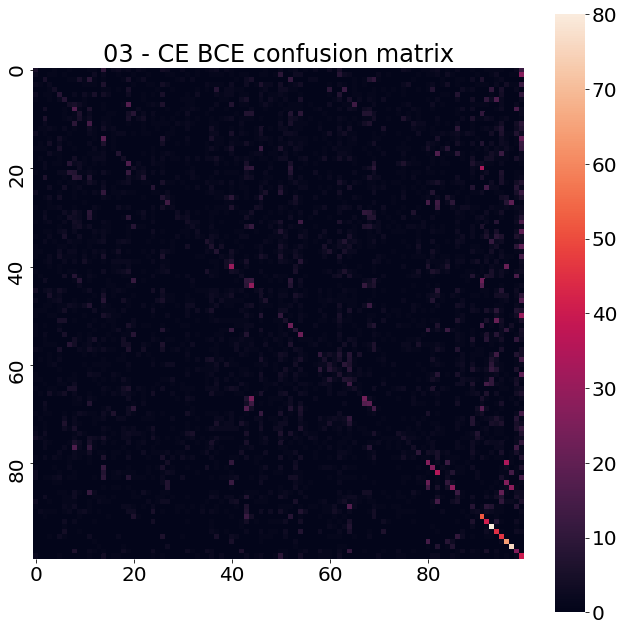

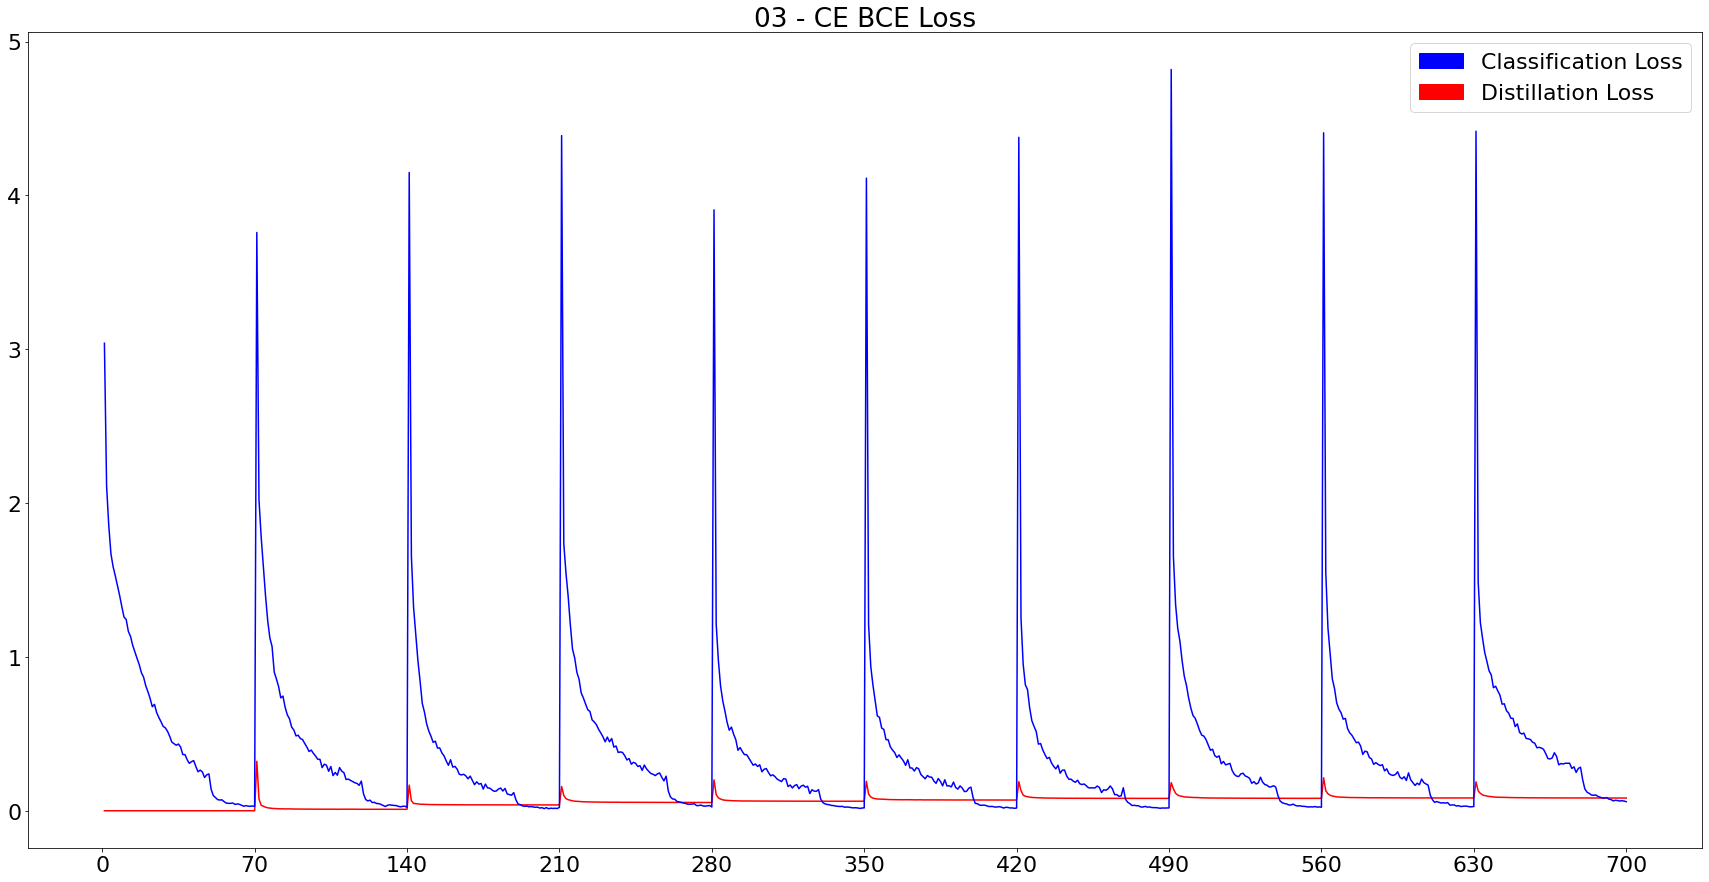

Files already downloaded and verified


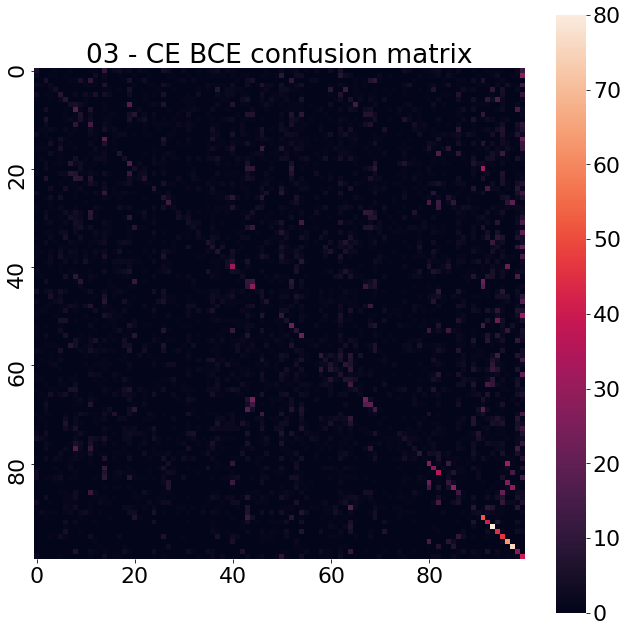

array([[ 5,  0,  0, ...,  0,  2, 12],
       [ 2,  0,  0, ...,  1,  1, 27],
       [ 0,  0,  5, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 76,  0,  0],
       [ 0,  0,  0, ...,  0, 26,  0],
       [ 2,  0,  0, ...,  0,  2, 40]])

In [ ]:
plt.rcParams['font.size'] = 20
icarl.compute_confusion_matrix(plot=True, title = "03 - CE BCE", cif = cifarTrain)
icarl.plotLosses(title = "03 - CE BCE")
plt.rcParams['font.size'] = 22
icarl.compute_confusion_matrix(plot=True, title = "03 - CE BCE", cif = cifarTrain)

log 1 + x

Files already downloaded and verified


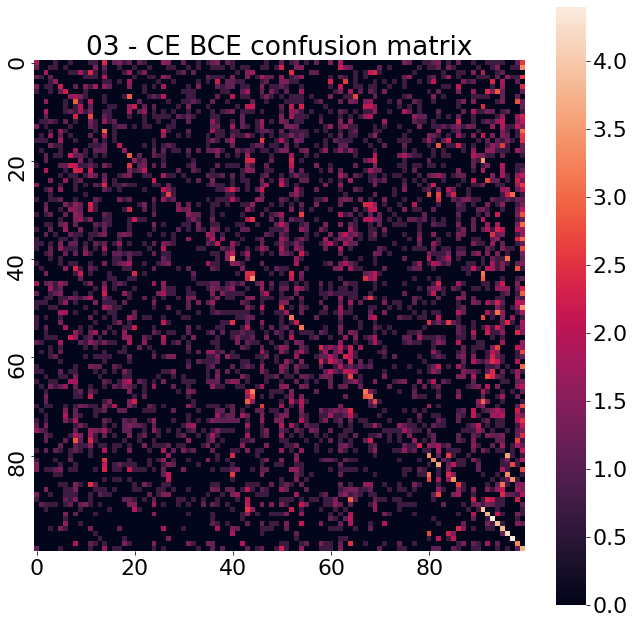

In [ ]:
title= "03 - CE BCE"
cifarTest = cifar_100(100, 'test')
dl = torch.utils.data.DataLoader(cifarTest, batch_size=128,shuffle=True, num_workers=4, drop_last=True)
mapper = cifarTrain.get_dictionary()
y_true = []
y_pred = []
for _, images, labels in dl:
  images = Variable(images).cuda()
  y_true.extend(labels)
  y_pred_tmp = icarl.classify(images, cifarTrain)
  y_pred_tmp = [p.item() for p in y_pred_tmp]
  y_pred.extend(y_pred_tmp)

y_true = [mapper[l.item()] for l in y_true]
acc_matrix = s_cm(y_true, y_pred)
acc_matrix = np.log(1+acc_matrix)

plt.figure(figsize=(11,11))
df_cm = pd.DataFrame(acc_matrix)
sn.heatmap(df_cm, square=True, xticklabels=20, yticklabels=20)
plt.title(f"{title} confusion matrix")
plt.show()

Acc

[ 10  20  30  40  50  60  70  80  90 100]


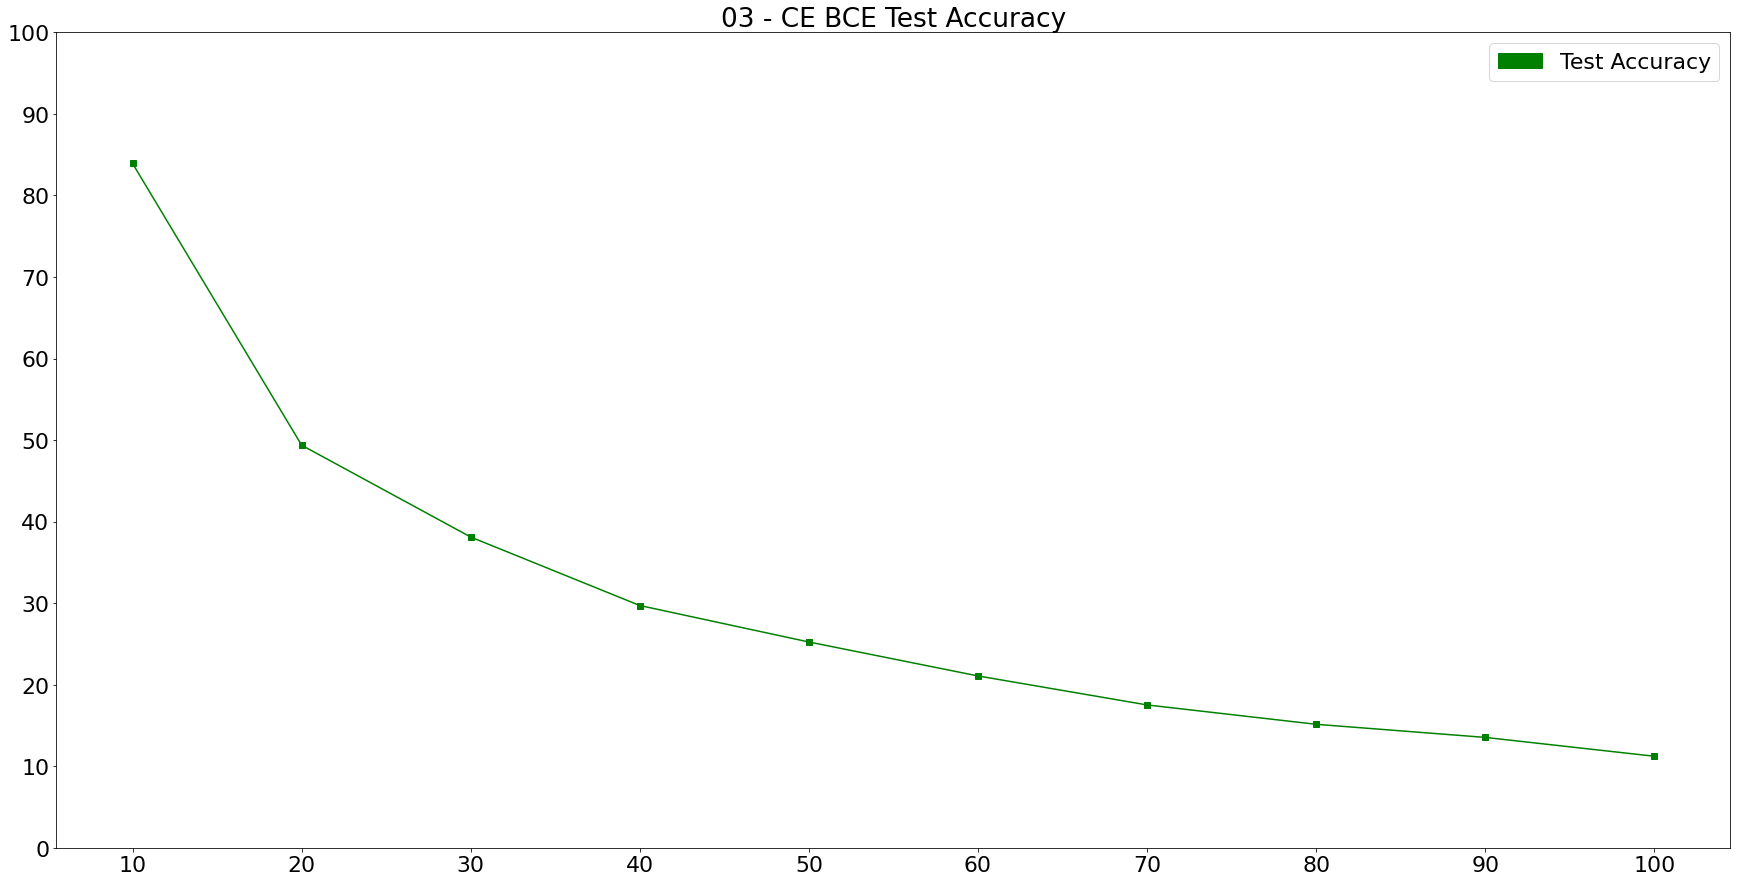

[ 10  20  30  40  50  60  70  80  90 100]


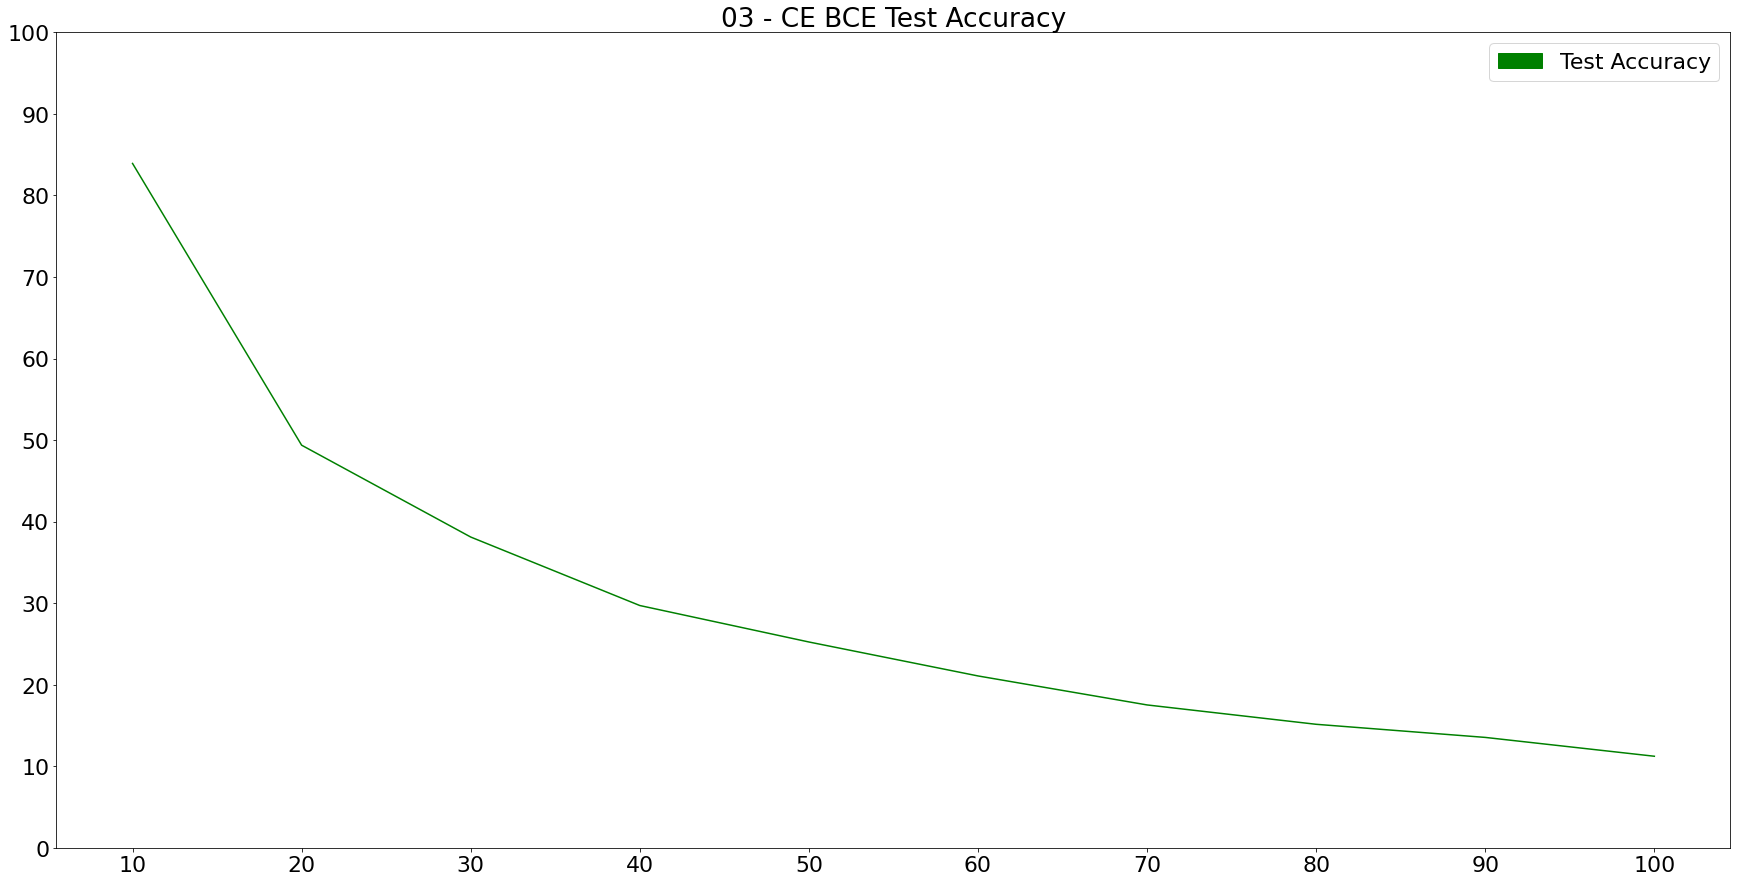

In [ ]:
title = "03 - CE BCE"
plt.rcParams['font.size'] = 22
x=np.arange(10, 110, 10)
y=np.arange(0, 110, 10)
print(x)
plt.figure(figsize=(30, 15))
b_patch = mpatches.Patch(color='green', label='Test Accuracy')
plt.legend(handles=[b_patch])
plt.plot(x ,acc_vect,'g', x ,acc_vect,'gs')
plt.title(f"{title} Test Accuracy")
plt.xticks(x)
plt.yticks(y)
# plt.savefig(f'1_accStats.png')
plt.show()

title =  "03 - CE BCE"
plt.rcParams['font.size'] = 22
x=np.arange(10, 110, 10)
y=np.arange(0, 110, 10)
print(x)
plt.figure(figsize=(30, 15))
b_patch = mpatches.Patch(color='green', label='Test Accuracy')
plt.legend(handles=[b_patch])
plt.plot(x ,acc_vect,'g')
plt.title(f"{title} Test Accuracy")
plt.xticks(x)
plt.yticks(y)
# plt.savefig(f'1_accStats.png')
plt.show()